In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

IMAGE_PATH = os.path.abspath(os.getcwd())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(os.path.abspath(os.getcwd()), fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [2]:
from tf_agents.environments import suite_gym

env = suite_gym.load("ALE/SpaceInvaders-v5")
env

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


In [3]:
print(env.get_info())
print(env.action_spec())
print(env.gym.get_action_meanings())

None
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Saving figure invader-plot


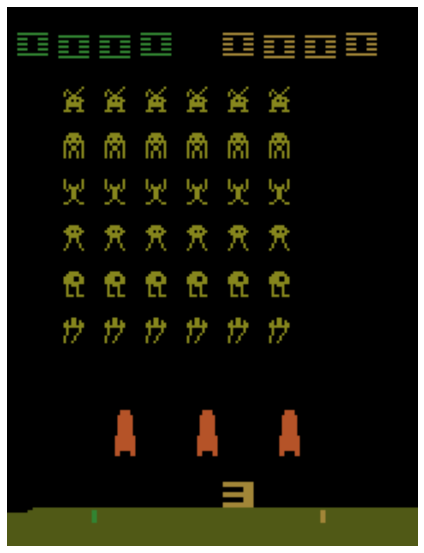

In [4]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("invader-plot")
plt.show()

In [6]:
from tf_agents.environments.wrappers import ActionRepeat
from gym.wrappers import TimeLimit
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4


class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
            super().step(0)
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40)
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            self.skip_frames(40)
        return obs, rewards, done, info


repeating_env = ActionRepeat(env, times=4)
limited_repeating_env = suite_gym.load(
    "SpaceInvaders-v4",
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
)
env = suite_gym.load(
    'SpaceInvaders-v4',
    max_episode_steps=27000,
    gym_env_wrappers=[AtariPreprocessingWithSkipStart, FrameStack4]
)

/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


In [7]:
import numpy as np

def draw_obs(obs): #Draw the Observation Screen
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")


/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


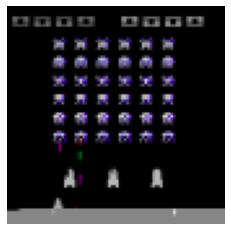

In [8]:
env.seed(32)

env.reset()
for _ in range(4): #Test control and get the trajectory
    time_step = env.step(3)

draw_obs(time_step.observation)
# save_fig('processed_invadar_game_pic')
plt.show()

In [9]:
from tf_agents.environments import TFPyEnvironment
import keras
import tensorflow as tf
from tf_agents.networks.q_network import QNetwork

tf_env = TFPyEnvironment(env)

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.) #Default layer design from book
fc_layer_params = [512]
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)


In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_steps = tf.Variable(0)
update_period = 4
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.1,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01)
agent = DqnAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_steps,
    epsilon_greedy=lambda:epsilon_fn(train_steps)
)
agent.initialize()

In [ ]:
agent

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.replay_buffers.py_hashed_replay_buffer import PyHashedReplayBuffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=500000
)

replay_buffer_observer = replay_buffer.add_batch

In [ ]:
class ShowProgress():
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [ ]:
collect_driver

In [19]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=100
)
final_time_step, final_policy_state = init_driver.run()

20000/20000

In [20]:
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=3)
print(trajectories)
print(buffer_info)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Trajectory(
{'action': <tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[0, 1, 5],
       [1, 1, 4]], dtype=int64)>,
 'discount': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]])>,
 'observation': <tf.Tensor: shape=(2, 3, 84, 84, 4), dtype=uint8, numpy=
array([[[[[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         ...,

         [[

In [21]:
print(trajectories._fields)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


In [22]:
print('Shape of \'observation\': ', trajectories.observation.shape)
print('Shape of \'rewards\': ', trajectories.reward.shape)
print(trajectories.step_type.numpy())

Shape of 'observation':  (2, 3, 84, 84, 4)
Shape of 'rewards':  (2, 3)
[[1 1 1]
 [1 1 1]]


Saving figure sub_episode_plot


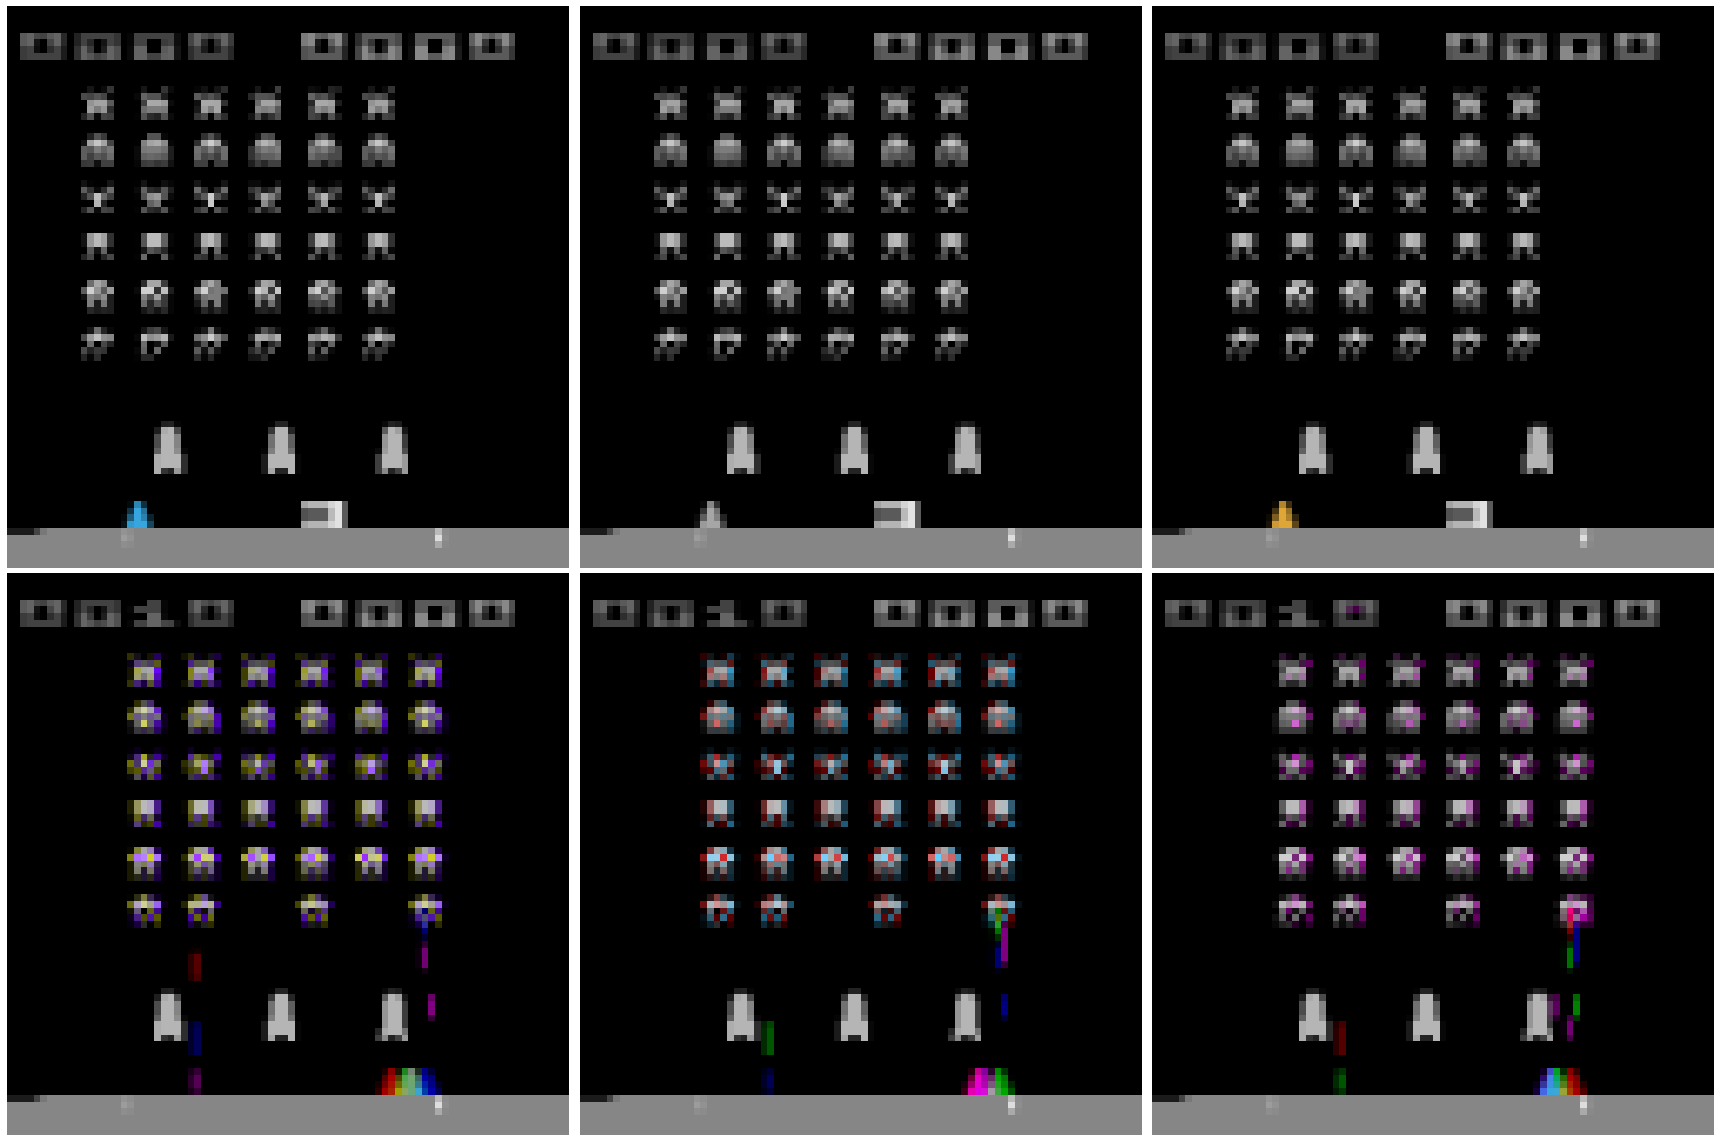

In [23]:
plt.figure(figsize=(24, 16))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row*3 + col+1)
        draw_obs(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig('sub_episode_plot')
plt.show()

簡單印出其中兩個 Trajectories

In [24]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=2)

In [25]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)


In [26]:
history = {"NumberOfEpisodes":[], "AverageReturn":[], "AverageEpisodeLength":[], "EvironmentSteps":[], "loss":[]}
returns = []

def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")
        history["loss"].append(train_loss.loss.numpy())
        if (iteration % 1000 == 0):
            returns.append(train_metrics[2])
            history["AverageReturn"].append(train_metrics[2])
            history["NumberOfEpisodes"].append(train_metrics[0])
            history["AverageEpisodeLength"].append(train_metrics[3])
            log_metrics(train_metrics)

In [28]:
train_agent(50000)

INFO:absl: 
		 NumberOfEpisodes = 42
		 EnvironmentSteps = 8320
		 AverageReturn = 164.0
		 AverageEpisodeLength = 210.89999389648438


997 loss:0.30279

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 12320
		 AverageReturn = 167.0
		 AverageEpisodeLength = 193.0


1997 loss:0.62060

INFO:absl: 
		 NumberOfEpisodes = 84
		 EnvironmentSteps = 16320
		 AverageReturn = 205.0
		 AverageEpisodeLength = 190.0


2997 loss:0.56820

INFO:absl: 
		 NumberOfEpisodes = 108
		 EnvironmentSteps = 20320
		 AverageReturn = 172.5
		 AverageEpisodeLength = 177.89999389648438


3996 loss:1.28103

INFO:absl: 
		 NumberOfEpisodes = 131
		 EnvironmentSteps = 24320
		 AverageReturn = 157.5
		 AverageEpisodeLength = 181.3000030517578


5000 loss:1.11348

INFO:absl: 
		 NumberOfEpisodes = 152
		 EnvironmentSteps = 28320
		 AverageReturn = 257.5
		 AverageEpisodeLength = 213.5


5996 loss:0.35151

INFO:absl: 
		 NumberOfEpisodes = 173
		 EnvironmentSteps = 32320
		 AverageReturn = 139.0
		 AverageEpisodeLength = 168.10000610351562


7000 loss:1.15402

INFO:absl: 
		 NumberOfEpisodes = 194
		 EnvironmentSteps = 36320
		 AverageReturn = 212.5
		 AverageEpisodeLength = 200.3000030517578


7998 loss:1.01299

INFO:absl: 
		 NumberOfEpisodes = 218
		 EnvironmentSteps = 40320
		 AverageReturn = 198.0
		 AverageEpisodeLength = 185.39999389648438


8996 loss:0.83534

INFO:absl: 
		 NumberOfEpisodes = 244
		 EnvironmentSteps = 44320
		 AverageReturn = 110.5
		 AverageEpisodeLength = 149.6999969482422


9998 loss:0.80116

INFO:absl: 
		 NumberOfEpisodes = 268
		 EnvironmentSteps = 48320
		 AverageReturn = 192.5
		 AverageEpisodeLength = 187.0


10996 loss:1.13841

INFO:absl: 
		 NumberOfEpisodes = 292
		 EnvironmentSteps = 52320
		 AverageReturn = 168.0
		 AverageEpisodeLength = 164.3000030517578


11998 loss:0.34773

INFO:absl: 
		 NumberOfEpisodes = 312
		 EnvironmentSteps = 56320
		 AverageReturn = 148.5
		 AverageEpisodeLength = 183.89999389648438


12997 loss:0.79074

INFO:absl: 
		 NumberOfEpisodes = 336
		 EnvironmentSteps = 60320
		 AverageReturn = 187.5
		 AverageEpisodeLength = 180.3000030517578


13996 loss:1.68400

INFO:absl: 
		 NumberOfEpisodes = 362
		 EnvironmentSteps = 64320
		 AverageReturn = 136.5
		 AverageEpisodeLength = 151.5


14997 loss:0.85293

INFO:absl: 
		 NumberOfEpisodes = 383
		 EnvironmentSteps = 68320
		 AverageReturn = 201.0
		 AverageEpisodeLength = 174.0


15999 loss:1.31969

INFO:absl: 
		 NumberOfEpisodes = 403
		 EnvironmentSteps = 72320
		 AverageReturn = 265.5
		 AverageEpisodeLength = 202.5


16997 loss:1.09910

INFO:absl: 
		 NumberOfEpisodes = 425
		 EnvironmentSteps = 76320
		 AverageReturn = 181.5
		 AverageEpisodeLength = 175.1999969482422


17999 loss:1.11884

INFO:absl: 
		 NumberOfEpisodes = 445
		 EnvironmentSteps = 80320
		 AverageReturn = 222.5
		 AverageEpisodeLength = 204.60000610351562


18999 loss:1.57024

INFO:absl: 
		 NumberOfEpisodes = 466
		 EnvironmentSteps = 84320
		 AverageReturn = 201.0
		 AverageEpisodeLength = 190.1999969482422


19996 loss:4.02357

INFO:absl: 
		 NumberOfEpisodes = 489
		 EnvironmentSteps = 88320
		 AverageReturn = 169.0
		 AverageEpisodeLength = 157.3000030517578


20996 loss:0.77202

INFO:absl: 
		 NumberOfEpisodes = 508
		 EnvironmentSteps = 92320
		 AverageReturn = 241.0
		 AverageEpisodeLength = 204.10000610351562


21999 loss:1.34172

INFO:absl: 
		 NumberOfEpisodes = 531
		 EnvironmentSteps = 96320
		 AverageReturn = 180.0
		 AverageEpisodeLength = 166.1999969482422


22997 loss:1.95102

INFO:absl: 
		 NumberOfEpisodes = 549
		 EnvironmentSteps = 100320
		 AverageReturn = 235.5
		 AverageEpisodeLength = 189.6999969482422


23996 loss:1.50600

INFO:absl: 
		 NumberOfEpisodes = 566
		 EnvironmentSteps = 104320
		 AverageReturn = 294.5
		 AverageEpisodeLength = 216.0


24996 loss:1.39932

INFO:absl: 
		 NumberOfEpisodes = 585
		 EnvironmentSteps = 108320
		 AverageReturn = 321.0
		 AverageEpisodeLength = 220.0


25998 loss:1.46832

INFO:absl: 
		 NumberOfEpisodes = 605
		 EnvironmentSteps = 112320
		 AverageReturn = 227.0
		 AverageEpisodeLength = 190.1999969482422


26996 loss:0.72886

INFO:absl: 
		 NumberOfEpisodes = 628
		 EnvironmentSteps = 116320
		 AverageReturn = 220.5
		 AverageEpisodeLength = 183.0


27997 loss:1.07615

INFO:absl: 
		 NumberOfEpisodes = 649
		 EnvironmentSteps = 120320
		 AverageReturn = 256.0
		 AverageEpisodeLength = 188.60000610351562


28997 loss:2.21611

INFO:absl: 
		 NumberOfEpisodes = 671
		 EnvironmentSteps = 124320
		 AverageReturn = 159.5
		 AverageEpisodeLength = 162.39999389648438


29997 loss:2.04232

INFO:absl: 
		 NumberOfEpisodes = 693
		 EnvironmentSteps = 128320
		 AverageReturn = 230.0
		 AverageEpisodeLength = 191.1999969482422


30999 loss:1.30470

INFO:absl: 
		 NumberOfEpisodes = 710
		 EnvironmentSteps = 132320
		 AverageReturn = 266.0
		 AverageEpisodeLength = 246.3000030517578


32000 loss:1.08793

INFO:absl: 
		 NumberOfEpisodes = 731
		 EnvironmentSteps = 136320
		 AverageReturn = 180.0
		 AverageEpisodeLength = 181.5


32996 loss:2.61637

INFO:absl: 
		 NumberOfEpisodes = 753
		 EnvironmentSteps = 140320
		 AverageReturn = 180.5
		 AverageEpisodeLength = 175.89999389648438


33999 loss:0.58825

INFO:absl: 
		 NumberOfEpisodes = 773
		 EnvironmentSteps = 144320
		 AverageReturn = 310.5
		 AverageEpisodeLength = 217.39999389648438


34997 loss:1.24729

INFO:absl: 
		 NumberOfEpisodes = 791
		 EnvironmentSteps = 148320
		 AverageReturn = 278.0
		 AverageEpisodeLength = 212.89999389648438


35999 loss:5.42579

INFO:absl: 
		 NumberOfEpisodes = 811
		 EnvironmentSteps = 152320
		 AverageReturn = 213.5
		 AverageEpisodeLength = 197.89999389648438


37000 loss:1.21633

INFO:absl: 
		 NumberOfEpisodes = 832
		 EnvironmentSteps = 156320
		 AverageReturn = 226.5
		 AverageEpisodeLength = 180.3000030517578


37997 loss:1.77861

INFO:absl: 
		 NumberOfEpisodes = 852
		 EnvironmentSteps = 160320
		 AverageReturn = 202.5
		 AverageEpisodeLength = 186.89999389648438


38998 loss:1.28426

INFO:absl: 
		 NumberOfEpisodes = 871
		 EnvironmentSteps = 164320
		 AverageReturn = 302.0
		 AverageEpisodeLength = 230.3000030517578


39997 loss:1.79496

INFO:absl: 
		 NumberOfEpisodes = 893
		 EnvironmentSteps = 168320
		 AverageReturn = 226.5
		 AverageEpisodeLength = 185.8000030517578


40998 loss:0.95985

INFO:absl: 
		 NumberOfEpisodes = 914
		 EnvironmentSteps = 172320
		 AverageReturn = 259.5
		 AverageEpisodeLength = 201.5


41997 loss:2.10487

INFO:absl: 
		 NumberOfEpisodes = 935
		 EnvironmentSteps = 176320
		 AverageReturn = 219.0
		 AverageEpisodeLength = 193.39999389648438


42996 loss:1.11541

INFO:absl: 
		 NumberOfEpisodes = 954
		 EnvironmentSteps = 180320
		 AverageReturn = 222.5
		 AverageEpisodeLength = 193.89999389648438


43998 loss:1.97210

INFO:absl: 
		 NumberOfEpisodes = 971
		 EnvironmentSteps = 184320
		 AverageReturn = 294.0
		 AverageEpisodeLength = 218.1999969482422


44997 loss:1.62581

INFO:absl: 
		 NumberOfEpisodes = 991
		 EnvironmentSteps = 188320
		 AverageReturn = 246.0
		 AverageEpisodeLength = 186.39999389648438


45998 loss:2.04977

INFO:absl: 
		 NumberOfEpisodes = 1009
		 EnvironmentSteps = 192320
		 AverageReturn = 255.0
		 AverageEpisodeLength = 199.3000030517578


46997 loss:2.28392

INFO:absl: 
		 NumberOfEpisodes = 1026
		 EnvironmentSteps = 196320
		 AverageReturn = 271.0
		 AverageEpisodeLength = 228.1999969482422


47999 loss:1.30820

INFO:absl: 
		 NumberOfEpisodes = 1043
		 EnvironmentSteps = 200320
		 AverageReturn = 248.5
		 AverageEpisodeLength = 215.3000030517578


49000 loss:1.06741

INFO:absl: 
		 NumberOfEpisodes = 1062
		 EnvironmentSteps = 204320
		 AverageReturn = 288.5
		 AverageEpisodeLength = 230.8000030517578


49999 loss:2.41402

In [ ]:
plt.plot(log_metrics(ActionRepeat))

In [30]:
tf.saved_model.save('test.h5')

TypeError: save() missing 1 required positional argument: 'export_dir'

In [32]:
from matplotlib import animation

frames = []

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()



C:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


1000/1000

In [33]:
plot_animation(frames)

In [40]:
import PIL
import os

frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
image_path = os.path.join("pictures", "invader.gif")
frame_images[0].save(image_path,format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
import base64
import IPython

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
import imageio

def create_policy_eval_video(policy, filename, num_episodes, fps=30):
    filename = filename + '.mp4'
    with imageio.get_writer(filename, fps=fps) as video:
        